In [2]:
from pathlib import Path
from ardi.dataset import SocialVAEDataset
import numpy as np
from ardi.prediction import LinearPredictor, PowerlawPredictor, SocialVAEPredictor, VelocityCalc, PrefVelocityCalc, Predictor

/home/adday/.virtualenvs/ardi-CRQfTZgZ/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# lp = LinearPredictor(8, VelocityCalc.LAST_DISPLACEMENT)
# pp = PowerlawPredictor(8, VelocityCalc.LAST_DISPLACEMENT, PrefVelocityCalc.FIX_MAG_ORACLE_DIR)
sp_8_12_fpc = SocialVAEPredictor("../models/social_vae_zara01_8_12/ckpt-best", 4, 5, 8, VelocityCalc.LAST_DISPLACEMENT)
sp_8_12_no_fpc = SocialVAEPredictor("../models/social_vae_zara01_8_12/ckpt-best", 4, 5, 8, VelocityCalc.LAST_DISPLACEMENT, fpc=False, device="cuda:0")
sp_5_8_fpc = SocialVAEPredictor("../models/social_vae_zara01_5_8/ckpt-best", 4, 5, 8, VelocityCalc.LAST_DISPLACEMENT)
sp_5_8_no_fpc = SocialVAEPredictor("../models/social_vae_zara01_5_8/ckpt-best", 4, 5, 8, VelocityCalc.LAST_DISPLACEMENT, fpc=False, device="cuda:0")
predictors = {
    # "Linear": lp,
    # "Powerlaw": pp,
    "SocialVAE-Zara-8-12-FPC": sp_8_12_fpc,
    "SocialVAE-Zara-8-12": sp_8_12_no_fpc,
    "SocialVAE-Zara-5-8-FPC": sp_5_8_fpc,
    "SocialVAE-Zara-5-8": sp_5_8_no_fpc,
}

In [4]:
test_ds = SocialVAEDataset("../../SocialVAE/data/zucker_day_controller_scene/19/cadrl/overtake/23_0.txt")

for pred in predictors:
    ades, fdes = predictors[pred].predict_dataset(test_ds, 5, [i for i in test_ds.agents if i != -1], False)
    print(pred, round(np.mean(ades), 4), round(np.mean(fdes), 4))


SocialVAE-Zara-8-12-FPC 0.2079 0.4313
SocialVAE-Zara-8-12 0.2568 0.4043
SocialVAE-Zara-5-8-FPC 0.2075 0.4385
SocialVAE-Zara-5-8 0.2582 0.5441


In [5]:
%matplotlib inline

from tqdm import tqdm
from typing import Dict, Tuple, List

def get_results(predictors: Dict[str, Predictor], root: str, glob: str, plot: bool) -> Dict[str, Dict[str, Tuple[List[float], List[float]]]]:
    results = {}

    for i, fn in tqdm(list(enumerate(Path(root).glob(glob)))):
        day, controller, scene = str(fn).split("/")[5:8]
        idx, offset = fn.stem.split("_")
        img_root = Path(f"./{controller}/{scene}")
        img_root.mkdir(parents=True, exist_ok=True)
        
        ds = SocialVAEDataset(str(fn))
        results[str(fn)] = {}

        for name in predictors:
            ade, fde = predictors[name].predict_dataset(
                ds,
                5,
                [i for i in ds.agents if i != -1],
                plot,
                str(img_root) + f"/{day}_{idx}_{offset}_{name.lower()}",
                name + " " + controller + " on " + scene
            )

            results[str(fn)][name] = ade, fde
        
    return results

In [6]:
from scipy.stats import kstest

def is_normal(data: np.ndarray, alpha: float=0.05) -> bool:
    data_c = np.copy(data)
    data_c -= np.mean(data_c)
    data_c /= np.std(data_c)
    stat, p = kstest(data_c, "norm")

    return p > alpha, stat, p

def get_results_normalicy(results: Dict[str, Dict[str, Tuple[List[float], List[float]]]]):
    return {
        pred: is_normal([x for x in [results[key][pred][0] for key in results] for x in x]) for pred in predictors
    }

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme()

def plot_results(results: Dict[str, Dict[str, Tuple[List[float], List[float]]]], title: str):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    plot_fn = sns.kdeplot

    for pred in predictors:
        plot_fn([x for x in [results[key][pred][0] for key in results] for x in x], label=pred, ax=axs[0], common_norm=False)
        plot_fn([x for x in [results[key][pred][1] for key in results] for x in x], label=pred, ax=axs[1], common_norm=False)

    axs[0].set_ylabel("ADE Density")
    axs[1].set_ylabel("FDE Density")

    plt.suptitle(title)
    plt.legend()

In [8]:
import pandas as pd

def df_results(results: Dict[str, Dict[str, Tuple[List[float], List[float]]]]):
    data = []
    for fn in results:
        infos = fn.split("/")
        controller = infos[-3]
        scene = infos[-2]
        file = infos[-1]
        for pred in results[fn]:
            data.append({
                "scene": scene,
                "predictor": pred,
                "filename": file,
                "controller": controller,
                "ade": np.mean(results[fn][pred][0]),
                "fde": np.mean(results[fn][pred][1]),
            })

    return pd.DataFrame(data)

100%|██████████| 816/816 [29:03<00:00,  2.14s/it]


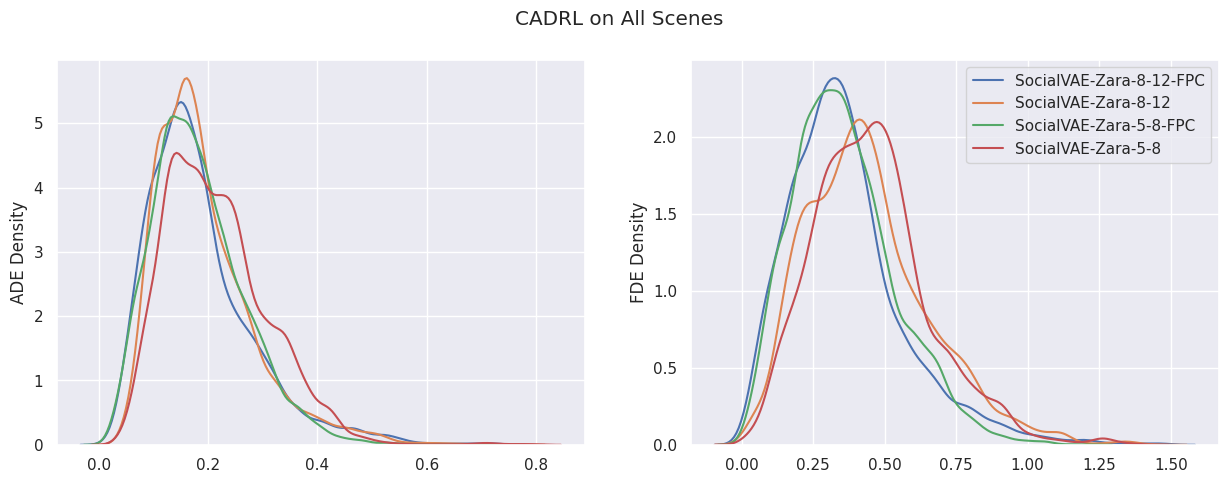

In [9]:
cadrl_results = get_results(predictors, "../../SocialVAE/data/zucker_day_controller_scene/", "./*/cadrl/*/*txt", False)
plot_results(cadrl_results, "CADRL on All Scenes")
cadrl_df = df_results(cadrl_results)

100%|██████████| 744/744 [26:08<00:00,  2.11s/it]


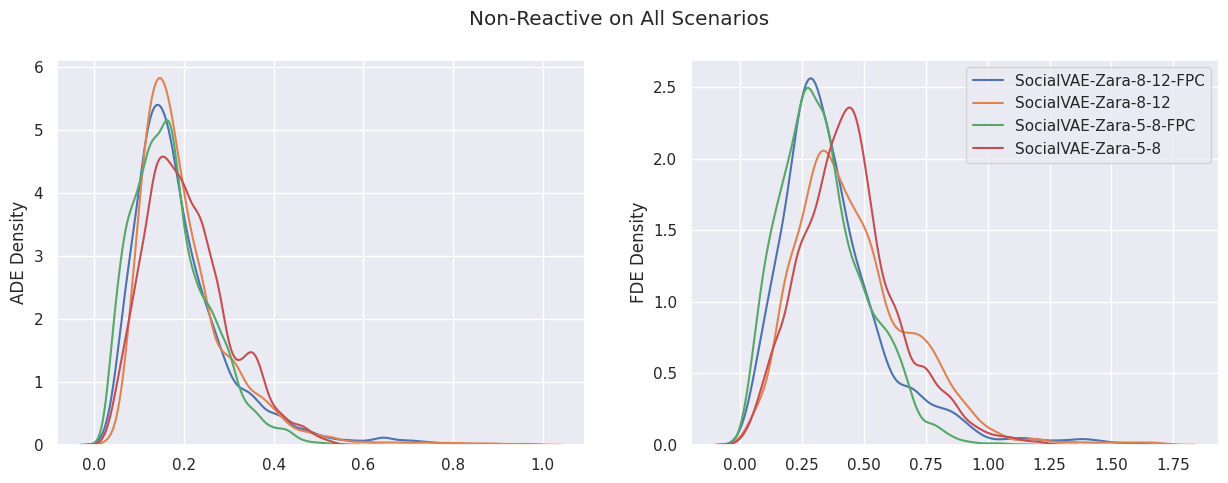

In [10]:
non_reactive_results = get_results(predictors, "../../SocialVAE/data/zucker_day_controller_scene/", "./*/non-reactive/*/*txt", False)
plot_results(non_reactive_results, "Non-Reactive on All Scenarios")
non_reactive_df = df_results(non_reactive_results)

100%|██████████| 384/384 [13:17<00:00,  2.08s/it]


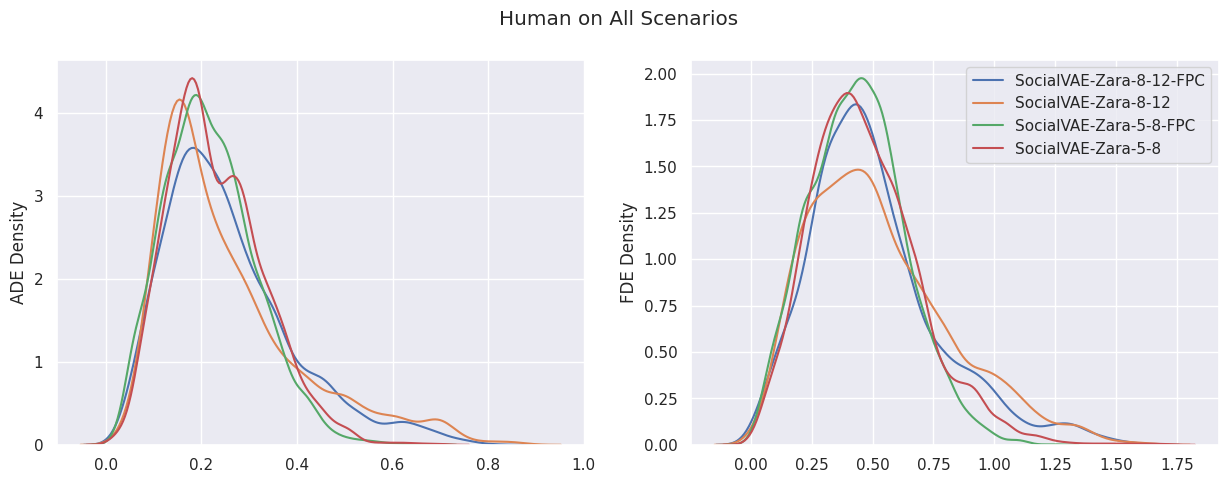

In [11]:
human_results = get_results(predictors, "../../SocialVAE/data/zucker_day_controller_scene/", "./*/human/*/*txt", False)
plot_results(human_results, "Human on All Scenarios")
human_df = df_results(human_results)

100%|██████████| 768/768 [25:54<00:00,  2.02s/it]


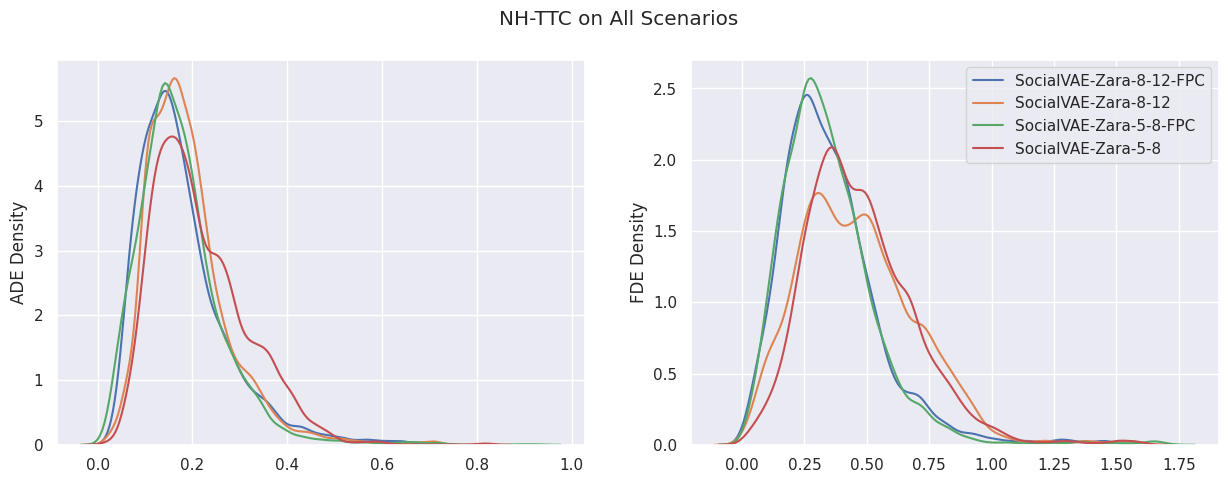

In [12]:
nhttc_results = get_results(predictors, "../../SocialVAE/data/zucker_day_controller_scene/", "./*/nhttc/*/*txt", False)
plot_results(nhttc_results, "NH-TTC on All Scenarios")
nhttc_df = df_results(nhttc_results)